<a href="https://colab.research.google.com/github/ipejun-ai/m5-accuracy/blob/master/m5_three_shades_of_dark_darker_magic_cat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# General imports
import numpy as np
import pandas as pd
import os, sys, gc, time, warnings, pickle, psutil, random

# custom imports
from multiprocessing import Pool        # Multiprocess Runs
import itertools

warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
DIRPATH="/content/gdrive/My Drive/kaggle/m5-forecasting-accuracy/"
#DIRPATH="C:/Users/peiju/Documents/Study/kaggle/m5-forecasting-accuracy/"

In [0]:
########################### Helpers
#################################################################################
## Seeder
# :seed to make all processes deterministic     # type: int
def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)

    
## Multiprocess Runs
def df_parallelize_run(func, t_split):
    num_cores = np.min([N_CORES,len(t_split)])
    pool = Pool(num_cores)
    df = pd.concat(pool.map(func, t_split), axis=1)
    pool.close()
    pool.join()
    return df

In [0]:
#nolimittation of store
def get_data():
  # Read and contact basic feature
    df = pd.concat([pd.read_pickle(BASE),
                    pd.read_pickle(PRICE).iloc[:,2:],
                    pd.read_pickle(CALENDAR).iloc[:,2:]],
                    axis=1)
    
    # Leave only relevant store
    #df = df[df['store_id']==store]

    # With memory limits we have to read 
    # lags and mean encoding features
    # separately and drop items that we don't need.
    # As our Features Grids are aligned 
    # we can use index to keep only necessary rows
    # Alignment is good for us as concat uses less memory than merge.
    #df5 = pd.read_pickle(EVENT_TYPE).iloc[:,2:]
    #df5 = df5[df5.index.isin(df.index)]
    df2 = pd.read_pickle(MEAN_ENC)[mean_features]
    df2 = df2[df2.index.isin(df.index)]
    
    df3 = pd.read_pickle(LAGS).iloc[:,3:]
    df3 = df3[df3.index.isin(df.index)]


    df4 = pd.read_pickle(SNAP).iloc[:,2:]
    df4 = df4[df4.index.isin(df.index)]
    
    df = pd.concat([df, df2], axis=1)
    del df2 # to not reach memory limit 
    
    df = pd.concat([df, df3], axis=1)
    del df3 # to not reach memory limit 

    df = pd.concat([df, df4], axis=1)
    del df4 # to not reach memory limit 

   

    
    # Create features list
    features = [col for col in list(df) if col not in remove_features]
    df = df[['id','d',TARGET]+features]
    
    # Skipping first n rows
    df = df[df['d']>=START_TRAIN].reset_index(drop=True)
    
    return df, features


In [0]:
########################### Helper to load data by store ID
#################################################################################
# Read data
def get_data_by_store(store):
    
    # Read and contact basic feature
    df = pd.concat([pd.read_pickle(BASE),
                    pd.read_pickle(PRICE).iloc[:,2:],
                    pd.read_pickle(CALENDAR).iloc[:,2:]],
                    axis=1)
    
    # Leave only relevant store
    df = df[df['store_id']==store]

    # With memory limits we have to read 
    # lags and mean encoding features
    # separately and drop items that we don't need.
    # As our Features Grids are aligned 
    # we can use index to keep only necessary rows
    # Alignment is good for us as concat uses less memory than merge.
    df2 = pd.read_pickle(MEAN_ENC)[mean_features]
    df2 = df2[df2.index.isin(df.index)]
    
    df3 = pd.read_pickle(LAGS).iloc[:,3:]
    df3 = df3[df3.index.isin(df.index)]


    df4 = pd.read_pickle(SNAP).iloc[:,2:]
    df4 = df4[df4.index.isin(df.index)]
    
    df = pd.concat([df, df2], axis=1)
    del df2 # to not reach memory limit 
    
    df = pd.concat([df, df3], axis=1)
    del df3 # to not reach memory limit 

    df = pd.concat([df, df4], axis=1)
    del df4 # to not reach memory limit 

   

    
    # Create features list
    features = [col for col in list(df) if col not in remove_features]
    df = df[['id','d',TARGET]+features]
    
    # Skipping first n rows
    df = df[df['d']>=START_TRAIN].reset_index(drop=True)
    
    return df, features

# Recombine Test set after training
def get_base_test():
    base_test = pd.DataFrame()

    for store_id,cat_id in itertools.product(STORES_IDS, CATEGORIES_IDS):
        #temp_df = pd.read_pickle('test_'+store_id+'.pkl')
        temp_df=pd.read_pickle('test_'+store_id+"_"+cat_id+'.pkl')
        temp_df['store_id'] = store_id
        temp_df['cat_id'] = cat_id
        base_test = pd.concat([base_test, temp_df]).reset_index(drop=True)
    
    return base_test


########################### Helper to make dynamic rolling lags
#################################################################################
def make_lag(LAG_DAY):
    lag_df = base_test[['id','d',TARGET]]
    col_name = 'sales_lag_'+str(LAG_DAY)
    lag_df[col_name] = lag_df.groupby(['id'])[TARGET].transform(lambda x: x.shift(LAG_DAY)).astype(np.float16)
    return lag_df[[col_name]]


def make_lag_roll(LAG_DAY):
    shift_day = LAG_DAY[0]
    roll_wind = LAG_DAY[1]
    lag_df = base_test[['id','d',TARGET]]
    col_name = 'rolling_mean_tmp_'+str(shift_day)+'_'+str(roll_wind)
    lag_df[col_name] = lag_df.groupby(['id'])[TARGET].transform(lambda x: x.shift(shift_day).rolling(roll_wind).mean())
    return lag_df[[col_name]]

In [0]:
########################### Model params
#################################################################################
import lightgbm as lgb
lgb_params = {
                    'boosting_type': 'gbdt',
                    'objective': 'tweedie',
                    'tweedie_variance_power': 1.1,
                    'metric': 'rmse',
                    'subsample': 0.5,
                    'subsample_freq': 1,
                    'learning_rate': 0.03,
                    'num_leaves': 2**11-1,
                    'min_data_in_leaf': 2**12-1,
                    'feature_fraction': 0.5,
                    'max_bin': 100,
                    'n_estimators': 1400,
                    'boost_from_average': False,
                    'verbose': -1,
                } 

# Let's look closer on params

## 'boosting_type': 'gbdt'
# we have 'goss' option for faster training
# but it normally leads to underfit.
# Also there is good 'dart' mode
# but it takes forever to train
# and model performance depends 
# a lot on random factor 
# https://www.kaggle.com/c/home-credit-default-risk/discussion/60921

## 'objective': 'tweedie'
# Tweedie Gradient Boosting for Extremely
# Unbalanced Zero-inflated Data
# https://arxiv.org/pdf/1811.10192.pdf
# and many more articles about tweediie
#
# Strange (for me) but Tweedie is close in results
# to my own ugly loss.
# My advice here - make OWN LOSS function
# https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/140564
# https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/143070
# I think many of you already using it (after poisson kernel appeared) 
# (kagglers are very good with "params" testing and tuning).
# Try to figure out why Tweedie works.
# probably it will show you new features options
# or data transformation (Target transformation?).

## 'tweedie_variance_power': 1.1
# default = 1.5
# set this closer to 2 to shift towards a Gamma distribution
# set this closer to 1 to shift towards a Poisson distribution
# my CV shows 1.1 is optimal 
# but you can make your own choice

## 'metric': 'rmse'
# Doesn't mean anything to us
# as competition metric is different
# and we don't use early stoppings here.
# So rmse serves just for general 
# model performance overview.
# Also we use "fake" validation set
# (as it makes part of the training set)
# so even general rmse score doesn't mean anything))
# https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/133834

## 'subsample': 0.5
# Serves to fight with overfit
# this will randomly select part of data without resampling
# Chosen by CV (my CV can be wrong!)
# Next kernel will be about CV

##'subsample_freq': 1
# frequency for bagging
# default value - seems ok

## 'learning_rate': 0.03
# Chosen by CV
# Smaller - longer training
# but there is an option to stop 
# in "local minimum"
# Bigger - faster training
# but there is a chance to
# not find "global minimum" minimum

## 'num_leaves': 2**11-1
## 'min_data_in_leaf': 2**12-1
# Force model to use more features
# We need it to reduce "recursive"
# error impact.
# Also it leads to overfit
# that's why we use small 
# 'max_bin': 100

## l1, l2 regularizations
# https://towardsdatascience.com/l1-and-l2-regularization-methods-ce25e7fc831c
# Good tiny explanation
# l2 can work with bigger num_leaves
# but my CV doesn't show boost
                    
## 'n_estimators': 1400
# CV shows that there should be
# different values for each state/store.
# Current value was chosen 
# for general purpose.
# As we don't use any early stopings
# careful to not overfit Public LB.

##'feature_fraction': 0.5
# LightGBM will randomly select 
# part of features on each iteration (tree).
# We have maaaany features
# and many of them are "duplicates"
# and many just "noise"
# good values here - 0.5-0.7 (by CV)

## 'boost_from_average': False
# There is some "problem"
# to code boost_from_average for 
# custom loss
# 'True' makes training faster
# BUT carefull use it
# https://github.com/microsoft/LightGBM/issues/1514
# not our case but good to know cons

In [0]:
########################### Vars
#################################################################################
VER = 3                          # Our model version
SEED = 42                        # We want all things
seed_everything(SEED)            # to be as deterministic 
lgb_params['seed'] = SEED        # as possible
N_CORES = psutil.cpu_count()     # Available CPU cores


#LIMITS and const
TARGET      = 'sales'            # Our target
START_TRAIN = 0                  # We can skip some rows (Nans/faster training)
END_TRAIN   = 1913               # End day of our train set
P_HORIZON   = 28                 # Prediction horizon
USE_AUX     = False            # Use or not pretrained models
USE_PKL     = False
#FEATURES to remove
## These features lead to overfit
## or values not present in test set
remove_features = ['id','state_id',
                   #'store_id',
                   'date','wm_yr_wk','d','snap_CA','snap_TX','snap_WI',TARGET]
mean_features   = ['enc_cat_id_mean','enc_cat_id_std',
                   'enc_dept_id_mean','enc_dept_id_std',
                   'enc_item_id_mean','enc_item_id_std'] 

#PATHS for Features
ORIGINAL = DIRPATH
BASE     = DIRPATH+'/output/m5-simple-fe/grid_part_1.pkl'
PRICE    = DIRPATH+'/output/m5-simple-fe/grid_part_2.pkl'
CALENDAR = DIRPATH+'/output/m5-simple-fe/grid_part_3.pkl'
LAGS     = DIRPATH+'/output/m5-lags-features/lags_df_28.pkl'
MEAN_ENC = DIRPATH+'/output/m5-custom-features/mean_encoding_df.pkl'
FINAL_SALES = DIRPATH+'/output/m5-custom-features/finalsales_df.pkl'
SNAP      =  DIRPATH+'/output/m5-custom-features/snap_df.pkl'
# AUX(pretrained) Models paths
AUX_MODELS = DIRPATH+'/output/m5-three-shades-of-dark-darker-magic/'


#STORES ids
STORES_IDS = pd.read_csv(ORIGINAL+'sales_train_validation.csv')['store_id']
STORES_IDS = list(STORES_IDS.unique())

#CATEGORY ids
CATEGORIES_IDS = pd.read_csv(ORIGINAL+'sales_train_validation.csv')['cat_id']
CATEGORIES_IDS = list(CATEGORIES_IDS.unique())


#SPLITS for lags creation
SHIFT_DAY  = 28
N_LAGS     = 15
LAGS_SPLIT = [col for col in range(SHIFT_DAY,SHIFT_DAY+N_LAGS)]
ROLS_SPLIT = []
for i in [1,7,14]:
    for j in [7,14,30,60]:
        ROLS_SPLIT.append([i,j])

In [0]:
########################### Aux Models
# If you don't want to wait hours and hours
# to have result you can train each store 
# in separate kernel and then just join result.

# If we want to use pretrained models we can 
## skip training 
## (in our case do dummy training
##  to show that we are good with memory
##  and you can safely use this (all kernel) code)
if USE_AUX:
    lgb_params['n_estimators'] = 2
    
# Here is some 'logs' that can compare
#Train CA_1
#[100]	valid_0's rmse: 2.02289
#[200]	valid_0's rmse: 2.0017
#[300]	valid_0's rmse: 1.99239
#[400]	valid_0's rmse: 1.98471
#[500]	valid_0's rmse: 1.97923
#[600]	valid_0's rmse: 1.97284
#[700]	valid_0's rmse: 1.96763
#[800]	valid_0's rmse: 1.9624
#[900]	valid_0's rmse: 1.95673
#[1000]	valid_0's rmse: 1.95201
#[1100]	valid_0's rmse: 1.9476
#[1200]	valid_0's rmse: 1.9434
#[1300]	valid_0's rmse: 1.9392
#[1400]	valid_0's rmse: 1.93446

#Train CA_2
#[100]	valid_0's rmse: 1.88949
#[200]	valid_0's rmse: 1.84767
#[300]	valid_0's rmse: 1.83653
#[400]	valid_0's rmse: 1.82909
#[500]	valid_0's rmse: 1.82265
#[600]	valid_0's rmse: 1.81725
#[700]	valid_0's rmse: 1.81252
#[800]	valid_0's rmse: 1.80736
#[900]	valid_0's rmse: 1.80242
#[1000]	valid_0's rmse: 1.79821
#[1100]	valid_0's rmse: 1.794
#[1200]	valid_0's rmse: 1.78973
#[1300]	valid_0's rmse: 1.78552
#[1400]	valid_0's rmse: 1.78158

In [0]:
if USE_PKL:
  grid_df_all=pd.read_pickle(AUX_MODELS+'grid_df_all_v'+str(VER)+'.pkl') 
  features=pd.read_csv(AUX_MODELS+'feature_v'+str(VER)+'.csv',header=None)
  features_columns=list(features[0])
else:
  grid_df_all, features_columns = get_data()
  grid_df_all.to_pickle(AUX_MODELS+'grid_df_all_v'+str(VER)+'.pkl')
  imp=pd.DataFrame({'feature': features_columns})
  imp.to_csv(AUX_MODELS+'feature_v'+str(VER)+'.csv', index=False)

In [12]:
grid_df_all.columns

Index(['id', 'd', 'sales', 'item_id', 'dept_id', 'cat_id', 'store_id',
       'release', 'sell_price', 'price_max', 'price_min', 'price_std',
       'price_mean', 'price_norm', 'price_nunique', 'item_nunique',
       'price_momentum', 'price_momentum_m', 'price_momentum_y',
       'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 'tm_d',
       'tm_w', 'tm_m', 'tm_y', 'tm_wm', 'tm_dw', 'tm_w_end', 'enc_cat_id_mean',
       'enc_cat_id_std', 'enc_dept_id_mean', 'enc_dept_id_std',
       'enc_item_id_mean', 'enc_item_id_std', 'sales_lag_28', 'sales_lag_29',
       'sales_lag_30', 'sales_lag_31', 'sales_lag_32', 'sales_lag_33',
       'sales_lag_34', 'sales_lag_35', 'sales_lag_36', 'sales_lag_37',
       'sales_lag_38', 'sales_lag_39', 'sales_lag_40', 'sales_lag_41',
       'sales_lag_42', 'rolling_mean_7', 'rolling_std_7', 'rolling_mean_14',
       'rolling_std_14', 'rolling_mean_30', 'rolling_std_30',
       'rolling_mean_60', 'rolling_std_60', 'rolling_mean_180',
       '

In [13]:
########################### Train Models
#################################################################################
#for store_id in STORES_IDS:
for store_id,cat_id in itertools.product(STORES_IDS, CATEGORIES_IDS):
    print('Train', store_id,cat_id)
    
    # Get grid for current store
    #grid_df, features_columns = get_data_by_store(store_id)
    grid_df=grid_df_all[(grid_df_all['store_id']==store_id) & (grid_df_all['cat_id']==cat_id) ]
    grid_df=grid_df.drop(["store_id","cat_id"],axis=1)
    features_columns=[x for x in features_columns if x not in ["store_id","cat_id"]]
    
    # Masks for 
    # Train (All data less than 1913)
    # "Validation" (Last 28 days - not real validatio set)
    # Test (All data greater than 1913 day, 
    #       with some gap for recursive features)
    train_mask = grid_df['d']<=END_TRAIN
    valid_mask = train_mask&(grid_df['d']>(END_TRAIN-P_HORIZON))
    preds_mask = grid_df['d']>(END_TRAIN-100)
    
    # Apply masks and save lgb dataset as bin
    # to reduce memory spikes during dtype convertations
    # https://github.com/Microsoft/LightGBM/issues/1032
    # "To avoid any conversions, you should always use np.float32"
    # or save to bin before start training
    # https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection/discussion/53773
    train_data = lgb.Dataset(grid_df[train_mask][features_columns], 
                       label=grid_df[train_mask][TARGET])
    train_data.save_binary('train_data.bin')
    train_data = lgb.Dataset('train_data.bin')
    
    valid_data = lgb.Dataset(grid_df[valid_mask][features_columns], 
                       label=grid_df[valid_mask][TARGET])
    
    # Saving part of the dataset for later predictions
    # Removing features that we need to calculate recursively 
    grid_df = grid_df[preds_mask].reset_index(drop=True)
    keep_cols = [col for col in list(grid_df) if '_tmp_' not in col]
    grid_df = grid_df[keep_cols]
    grid_df.to_pickle('test_'+store_id+"_"+cat_id+'.pkl')
    del grid_df
    
    # Launch seeder again to make lgb training 100% deterministic
    # with each "code line" np.random "evolves" 
    # so we need (may want) to "reset" it
    seed_everything(SEED)
    estimator = lgb.train(lgb_params,
                          train_data,
                          valid_sets = [valid_data],
                          verbose_eval = 100,
                          )
    
    # Save model - it's not real '.bin' but a pickle file
    # estimator = lgb.Booster(model_file='model.txt')
    # can only predict with the best iteration (or the saving iteration)
    # pickle.dump gives us more flexibility
    # like estimator.predict(TEST, num_iteration=100)
    # num_iteration - number of iteration want to predict with, 
    # NULL or <= 0 means use best iteration
    model_name = AUX_MODELS+'lgb_model_'+store_id+"_"+cat_id+'_v'+str(VER)+'.bin'
    pickle.dump(estimator, open(model_name, 'wb'))

    # Remove temporary files and objects 
    # to free some hdd space and ram memory
    !rm train_data.bin
    del train_data, valid_data, estimator
    gc.collect()
    
    # "Keep" models features for predictions
    MODEL_FEATURES = features_columns

Train CA_1 HOBBIES
[100]	valid_0's rmse: 2.12422
[200]	valid_0's rmse: 2.10994
[300]	valid_0's rmse: 2.10347
[400]	valid_0's rmse: 2.09828
[500]	valid_0's rmse: 2.09491
[600]	valid_0's rmse: 2.09146
[700]	valid_0's rmse: 2.08719
[800]	valid_0's rmse: 2.08296
[900]	valid_0's rmse: 2.07844
[1000]	valid_0's rmse: 2.07409
[1100]	valid_0's rmse: 2.06983
[1200]	valid_0's rmse: 2.06595
[1300]	valid_0's rmse: 2.06114
[1400]	valid_0's rmse: 2.05891
Train CA_1 HOUSEHOLD
[100]	valid_0's rmse: 1.37109
[200]	valid_0's rmse: 1.34045
[300]	valid_0's rmse: 1.33018
[400]	valid_0's rmse: 1.32511
[500]	valid_0's rmse: 1.32124
[600]	valid_0's rmse: 1.31745
[700]	valid_0's rmse: 1.31459
[800]	valid_0's rmse: 1.31132
[900]	valid_0's rmse: 1.30857
[1000]	valid_0's rmse: 1.30647
[1100]	valid_0's rmse: 1.30388
[1200]	valid_0's rmse: 1.30225
[1300]	valid_0's rmse: 1.29997
[1400]	valid_0's rmse: 1.29756
Train CA_1 FOODS
[100]	valid_0's rmse: 2.37134
[200]	valid_0's rmse: 2.34274
[300]	valid_0's rmse: 2.33007
[40

# Evaluation

In [0]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()
import gc

from sklearn import preprocessing
import lightgbm as lgb

from typing import Union
from tqdm.notebook import tqdm_notebook as tqdm

In [0]:
class WRMSSEEvaluator(object):

    def __init__(self, train_df: pd.DataFrame, valid_df: pd.DataFrame, 
                 calendar: pd.DataFrame, prices: pd.DataFrame):
        train_y = train_df.loc[:, train_df.columns.str.startswith('d_')]
        train_target_columns = train_y.columns.tolist()
        weight_columns = train_y.iloc[:, -28:].columns.tolist()

        train_df['all_id'] = 'all'  # for lv1 aggregation

        id_columns = train_df.loc[:, ~train_df.columns.str.startswith('d_')]\
                     .columns.tolist()
        valid_target_columns = valid_df.loc[:, valid_df.columns.str.startswith('d_')]\
                               .columns.tolist()

        if not all([c in valid_df.columns for c in id_columns]):
            valid_df = pd.concat([train_df[id_columns], valid_df], 
                                 axis=1, sort=False)

        self.train_df = train_df
        self.valid_df = valid_df
        self.calendar = calendar
        self.prices = prices

        self.weight_columns = weight_columns
        self.id_columns = id_columns
        self.valid_target_columns = valid_target_columns

        weight_df = self.get_weight_df()

        self.group_ids = (
            'all_id',
            'state_id',
            'store_id',
            'cat_id',
            'dept_id',
            ['state_id', 'cat_id'],
            ['state_id', 'dept_id'],
            ['store_id', 'cat_id'],
            ['store_id', 'dept_id'],
            'item_id',
            ['item_id', 'state_id'],
            ['item_id', 'store_id']
        )

        for i, group_id in enumerate(tqdm(self.group_ids)):
            train_y = train_df.groupby(group_id)[train_target_columns].sum()
            scale = []
            for _, row in train_y.iterrows():
                series = row.values[np.argmax(row.values != 0):]
                scale.append(((series[1:] - series[:-1]) ** 2).mean())
            setattr(self, f'lv{i + 1}_scale', np.array(scale))
            setattr(self, f'lv{i + 1}_train_df', train_y)
            setattr(self, f'lv{i + 1}_valid_df', valid_df.groupby(group_id)\
                    [valid_target_columns].sum())

            lv_weight = weight_df.groupby(group_id)[weight_columns].sum().sum(axis=1)
            setattr(self, f'lv{i + 1}_weight', lv_weight / lv_weight.sum())

    def get_weight_df(self) -> pd.DataFrame:
        day_to_week = self.calendar.set_index('d')['wm_yr_wk'].to_dict()
        weight_df = self.train_df[['item_id', 'store_id'] + self.weight_columns]\
                    .set_index(['item_id', 'store_id'])
        weight_df = weight_df.stack().reset_index()\
                   .rename(columns={'level_2': 'd', 0: 'value'})
        weight_df['wm_yr_wk'] = weight_df['d'].map(day_to_week)

        weight_df = weight_df.merge(self.prices, how='left',
                                    on=['item_id', 'store_id', 'wm_yr_wk'])
        weight_df['value'] = weight_df['value'] * weight_df['sell_price']
        weight_df = weight_df.set_index(['item_id', 'store_id', 'd'])\
                    .unstack(level=2)['value']\
                    .loc[zip(self.train_df.item_id, self.train_df.store_id), :]\
                    .reset_index(drop=True)
        weight_df = pd.concat([self.train_df[self.id_columns],
                               weight_df], axis=1, sort=False)
        return weight_df

    def rmsse(self, valid_preds: pd.DataFrame, lv: int) -> pd.Series:
        valid_y = getattr(self, f'lv{lv}_valid_df')
        score = ((valid_y - valid_preds) ** 2).mean(axis=1)
        scale = getattr(self, f'lv{lv}_scale')
        return (score / scale).map(np.sqrt) 

    def score(self, valid_preds: Union[pd.DataFrame, 
                                       np.ndarray]) -> float:
        assert self.valid_df[self.valid_target_columns].shape \
               == valid_preds.shape

        if isinstance(valid_preds, np.ndarray):
            valid_preds = pd.DataFrame(valid_preds, 
                                       columns=self.valid_target_columns)

        valid_preds = pd.concat([self.valid_df[self.id_columns], 
                                 valid_preds], axis=1, sort=False)

        all_scores = []
        for i, group_id in enumerate(self.group_ids):

            valid_preds_grp = valid_preds.groupby(group_id)[self.valid_target_columns].sum()
            setattr(self, f'lv{i + 1}_valid_preds', valid_preds_grp)
            
            lv_scores = self.rmsse(valid_preds_grp, i + 1)
            setattr(self, f'lv{i + 1}_scores', lv_scores)
            
            weight = getattr(self, f'lv{i + 1}_weight')
            lv_scores = pd.concat([weight, lv_scores], axis=1, 
                                  sort=False).prod(axis=1)
            
            all_scores.append(lv_scores.sum())
            
        self.all_scores = all_scores

        return np.mean(all_scores)

In [22]:
########################### Predict Train & Valid
#################################################################################

# Create Dummy DataFrame to store predictions
all_preds = pd.DataFrame()

for store_id,cat_id in itertools.product(STORES_IDS, CATEGORIES_IDS):
#for store_id in ["CA_1"]:
    print('Predict', store_id, cat_id)
    
    # Get grid for current store
    #grid_df, features_columns = get_data_by_store(store_id)
    grid_df=grid_df_all[(grid_df_all['store_id']==store_id) & (grid_df_all['cat_id']==cat_id) ]
    grid_df=grid_df.drop(["store_id","cat_id"],axis=1)
    features_columns=[x for x in features_columns if x not in ["store_id","cat_id"]]
    ##borutaで選択した特徴量に変換
    #features_columns=[x for x in features_columns if x in selected_feature]
    
    # Masks for 
    # Train (All data less than 1913)
    # "Validation" (Last 28 days - not real validatio set)
    # Test (All data greater than 1913 day, 
    #       with some gap for recursive features)
    train_mask = grid_df['d']<=END_TRAIN
    valid_mask = train_mask&(grid_df['d']>(END_TRAIN-P_HORIZON))
    preds_mask = grid_df['d']>(END_TRAIN-100)
    
    # Apply masks and save lgb dataset as bin
    # to reduce memory spikes during dtype convertations
    # https://github.com/Microsoft/LightGBM/issues/1032
    # "To avoid any conversions, you should always use np.float32"
    # or save to bin before start training
    # https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection/discussion/53773
    train_data = lgb.Dataset(grid_df[train_mask][features_columns], 
                       label=grid_df[train_mask][TARGET])
    train_data.save_binary('train_data.bin')
    train_data = lgb.Dataset('train_data.bin')
    
    valid_data = lgb.Dataset(grid_df[valid_mask][features_columns], 
                       label=grid_df[valid_mask][TARGET])
    
    # Saving part of the dataset for later predictions
    # Removing features that we need to calculate recursively 
    #grid_df = grid_df[valid_mask]
    
    
    #del grid_df
    

    #model_path = AUX_MODELS + 'lgb_model_'+store_id+'_v'+str(VER)+'.bin' 
    model_path=AUX_MODELS+'lgb_model_'+store_id+"_"+cat_id+'_v'+str(VER)+'.bin'
    if USE_AUX:
        model_path = model_path
        
    estimator = pickle.load(open(model_path, 'rb'))
    pred_y=estimator.predict(grid_df[valid_mask][features_columns])
    print(pred_y)
    #tempoary data frame for predict
    temp_df=grid_df[valid_mask][["id","d"]].copy()
    temp_df[TARGET]=pred_y
    temp_df["store_id"]=store_id
    temp_df["cat_id"]=cat_id
    temp_df=temp_df.pivot_table(values=["sales"],columns=['d'],index=["id","store_id","cat_id"],aggfunc='sum')
    
    
    
    if len(all_preds)>0:
        all_preds = pd.concat([all_preds,temp_df])
    else:
        all_preds = temp_df.copy()

    all_preds.values.shape
    # Remove temporary files and objects 
    # to free some hdd space and ram memory
    !rm train_data.bin
    del train_data, valid_data, estimator
    gc.collect()
    
    # "Keep" models features for predictions
    MODEL_FEATURES = features_columns


Predict CA_1 HOBBIES
[0.87924473 0.19534045 0.35694557 ... 0.43917466 0.23035298 0.21730877]
Predict CA_1 HOUSEHOLD
[0.45195211 0.03550179 0.8966195  ... 0.42403386 0.01888866 0.31257417]
Predict CA_1 FOODS
[0.68138778 0.47497611 0.723727   ... 1.47352697 1.25859237 6.98917676]
Predict CA_2 HOBBIES
[0.63089026 0.05222041 0.35375897 ... 0.41201325 0.24730228 0.52515491]
Predict CA_2 HOUSEHOLD
[0.75527438 0.83732672 0.81106097 ... 0.72002346 0.42518091 0.30569344]
Predict CA_2 FOODS
[1.02350998 0.67311535 0.93758064 ... 1.34308117 1.37649804 5.07579356]
Predict CA_3 HOBBIES
[0.88586839 0.07758261 0.28693571 ... 0.25438338 0.18024703 0.26352201]
Predict CA_3 HOUSEHOLD
[0.58413112 0.75479485 1.68912519 ... 0.2354921  0.23970874 0.17258831]
Predict CA_3 FOODS
[0.8670351  0.48056962 0.68472349 ... 2.67304428 2.09877211 6.44902824]
Predict CA_4 HOBBIES
[0.87012213 0.10252571 0.15101681 ... 0.12461491 0.12109369 0.26503057]
Predict CA_4 HOUSEHOLD
[0.42658012 0.73722649 0.491325   ... 0.1961968

In [23]:
#reload data
d_dtypes = {}
for i in range(1914):
    d_dtypes[f'd_{i}'] = np.int32
sales = pd.read_csv(DIRPATH + 'sales_train_validation.csv',
                    dtype=d_dtypes)

# changing wide format to long format for model training
d = ['d_' + str(i) for i in range(1802,1914)]
sales_mlt = pd.melt(sales, id_vars=['item_id','dept_id','cat_id','store_id',
                                    'state_id'], value_vars=d)
sales_mlt = sales_mlt.rename(columns={'variable':'d', 'value':'sales'})

calendar = pd.read_csv(DIRPATH + 'calendar.csv',
                       dtype={'wm_yr_wk': np.int32, 'wday': np.int32, 
                              'month': np.int32, 'year': np.int32, 
                              'snap_CA': np.int32, 'snap_TX': np.int32,
                              'snap_WI': np.int32})

# subsetting calender by traning period
calendar = calendar.loc[calendar.d.apply(lambda x: int(x[2:])) \
                        >= int(sales_mlt.d[0][2:]), :]

prices = pd.read_csv(DIRPATH + 'sell_prices.csv',
                          dtype={'wm_yr_wk': np.int32, 
                                 'sell_price': np.float32})

train_df = sales.iloc[:, :-28]
valid_df = sales.iloc[:, -28:]

evaluator = WRMSSEEvaluator(train_df, valid_df, calendar, prices)

#sort
all_preds=pd.merge(train_df["id"],all_preds,on="id",how="left")
all_preds=all_preds.drop("id",axis=1)

WRMSSEE = evaluator.score(all_preds.values)

In [0]:
def create_viz_df(df,lv):
    
    df = df.T.reset_index()
    if lv in [6,7,8,9,11,12]:
        df.columns = [i[0] + '_' + i[1] if i != ('index','') \
                      else i[0] for i in df.columns]
    df = df.merge(calendar.loc[:, ['d','date']], how='left', 
                  left_on='index', right_on='d')
    df['date'] = pd.to_datetime(df.date)
    df = df.set_index('date')
    df = df.drop(['index', 'd'], axis=1)
    
    return df

def create_dashboard(evaluator):
    
    wrmsses = [np.mean(evaluator.all_scores)] + evaluator.all_scores
    labels = ['Overall'] + [f'Level {i}' for i in range(1, 13)]

    ## WRMSSE by Level
    plt.figure(figsize=(12,5))
    ax = sns.barplot(x=labels, y=wrmsses)
    ax.set(xlabel='', ylabel='WRMSSE')
    plt.title('WRMSSE by Level', fontsize=20, fontweight='bold')
    for index, val in enumerate(wrmsses):
        ax.text(index*1, val+.01, round(val,4), color='black', 
                ha="center")
        
    # configuration array for the charts
    n_rows = [1, 1, 4, 1, 3, 3, 3, 3, 3, 3, 3, 3]
    n_cols = [1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
    width = [7, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14]
    height = [4, 3, 12, 3, 9, 9, 9, 9, 9, 9, 9, 9]
    
    for i in range(1,13):
        
        scores = getattr(evaluator, f'lv{i}_scores')
        weights = getattr(evaluator, f'lv{i}_weight')
        
        if i > 1 and i < 9:
            if i < 7:
                fig, axs = plt.subplots(1, 2, figsize=(12, 3))
            else:
                fig, axs = plt.subplots(2, 1, figsize=(12, 8))
                
            ## RMSSE plot
            scores.plot.bar(width=.8, ax=axs[0], color='g')
            axs[0].set_title(f"RMSSE", size=14)
            axs[0].set(xlabel='', ylabel='RMSSE')
            if i >= 4:
                axs[0].tick_params(labelsize=8)
            for index, val in enumerate(scores):
                axs[0].text(index*1, val+.01, round(val,4), color='black', 
                            ha="center", fontsize=10 if i == 2 else 8)
            
            ## Weight plot
            weights.plot.bar(width=.8, ax=axs[1])
            axs[1].set_title(f"Weight", size=14)
            axs[1].set(xlabel='', ylabel='Weight')
            if i >= 4:
                axs[1].tick_params(labelsize=8)
            for index, val in enumerate(weights):
                axs[1].text(index*1, val+.01, round(val,2), color='black', 
                            ha="center", fontsize=10 if i == 2 else 8)
                    
            fig.suptitle(f'Level {i}: {evaluator.group_ids[i-1]}', size=24 ,
                         y=1.1, fontweight='bold')
            plt.tight_layout()
            plt.show()

        trn = create_viz_df(getattr(evaluator, f'lv{i}_train_df')\
                            .iloc[:, -28*3:], i)
        val = create_viz_df(getattr(evaluator, f'lv{i}_valid_df'), i)
        pred = create_viz_df(getattr(evaluator, f'lv{i}_valid_preds'), i)

        n_cate = trn.shape[1] if i < 7 else 9

        fig, axs = plt.subplots(n_rows[i-1], n_cols[i-1], 
                                figsize=(width[i-1],height[i-1]))
        if i > 1:
            axs = axs.flatten()

        ## Time series plot
        for k in range(0, n_cate):

            ax = axs[k] if i > 1 else axs

            trn.iloc[:, k].plot(ax=ax, label='train')
            val.iloc[:, k].plot(ax=ax, label='valid')
            pred.iloc[:, k].plot(ax=ax, label='pred')
            ax.set_title(f"{trn.columns[k]}  RMSSE:{scores[k]:.4f}", size=14)
            ax.set(xlabel='', ylabel='sales')
            ax.tick_params(labelsize=8)
            ax.legend(loc='upper left', prop={'size': 10})

        if i == 1 or i >= 9:
            fig.suptitle(f'Level {i}: {evaluator.group_ids[i-1]}', size=24 , 
                         y=1.1, fontweight='bold')
        plt.tight_layout()
        plt.show()

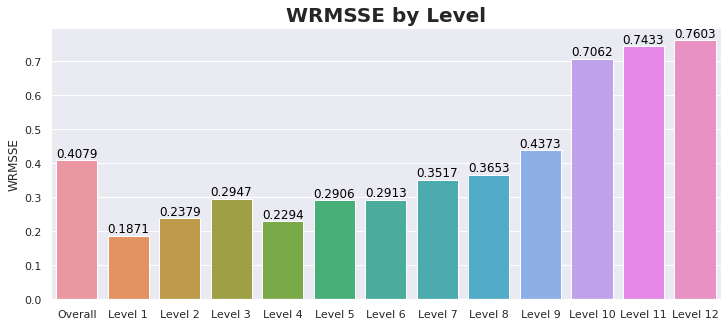

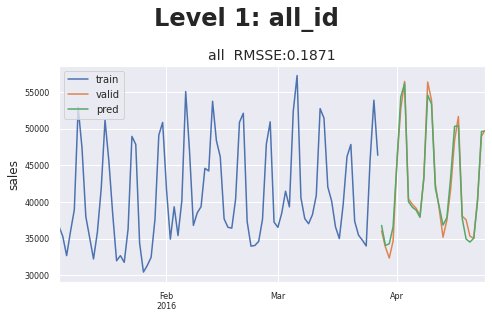

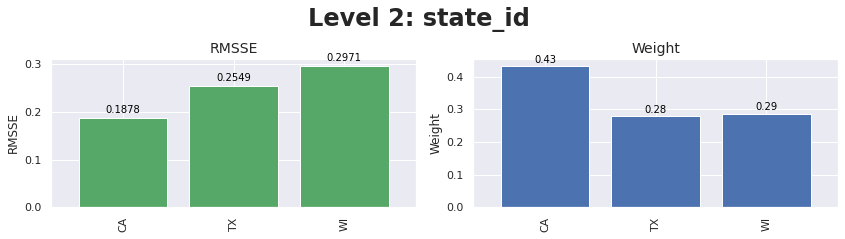

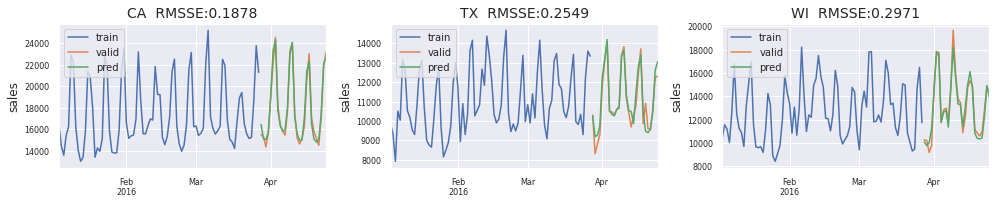

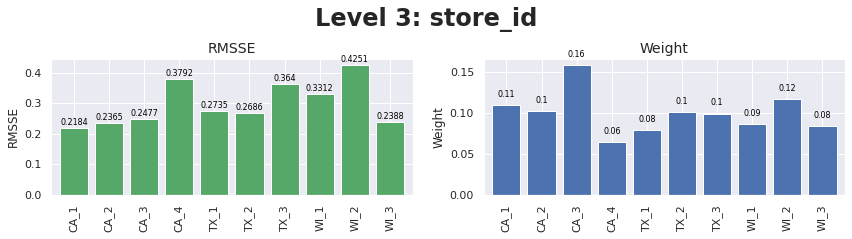

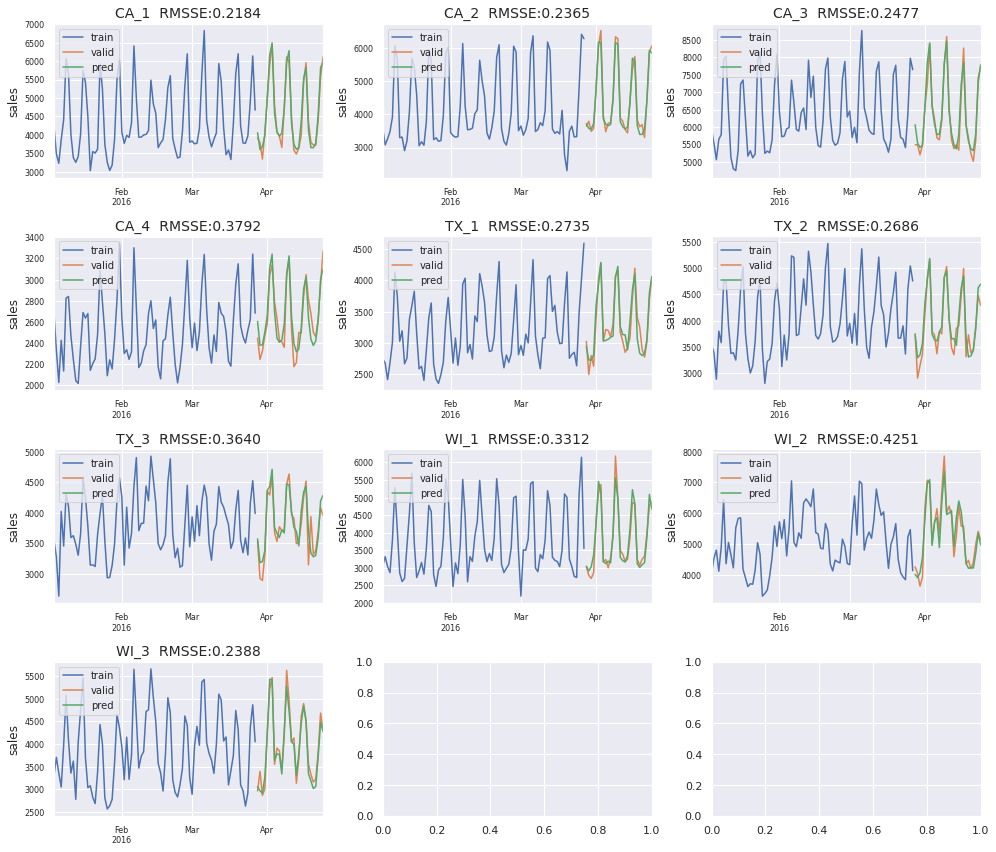

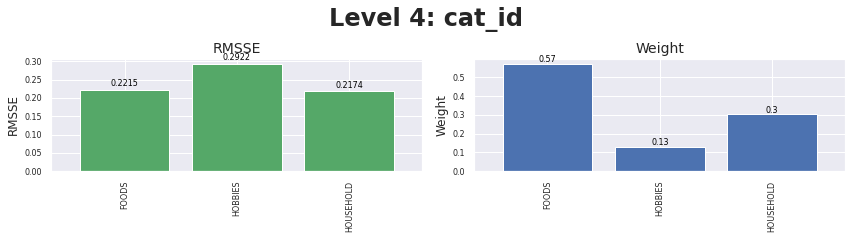

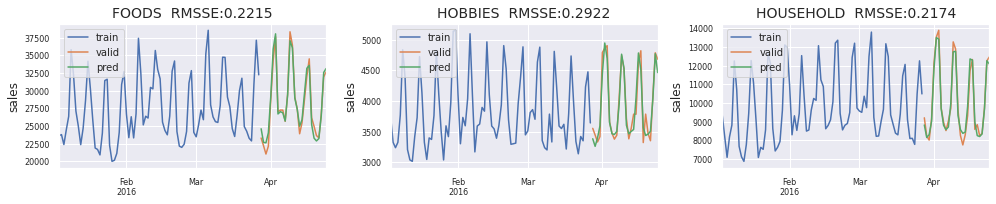

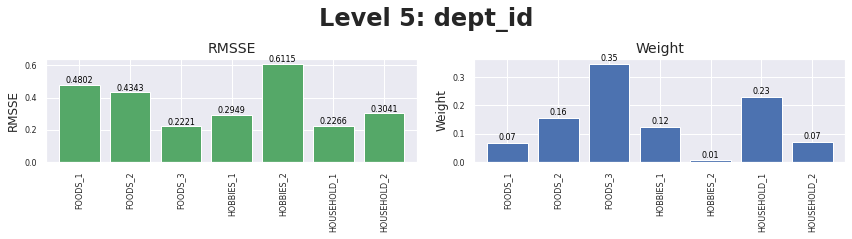

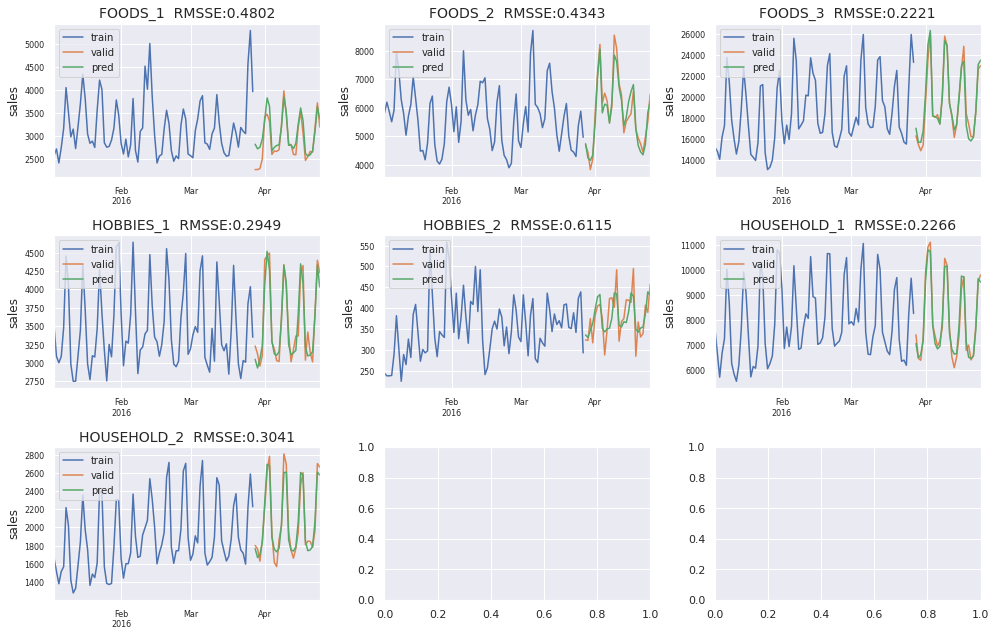

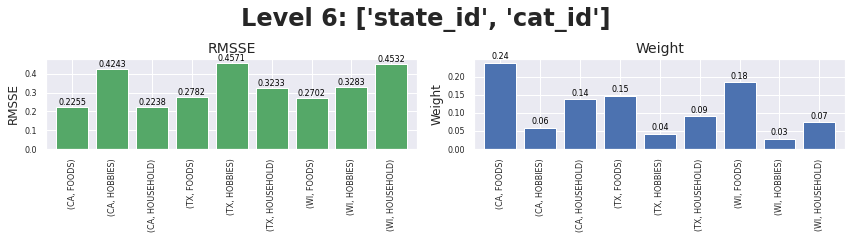

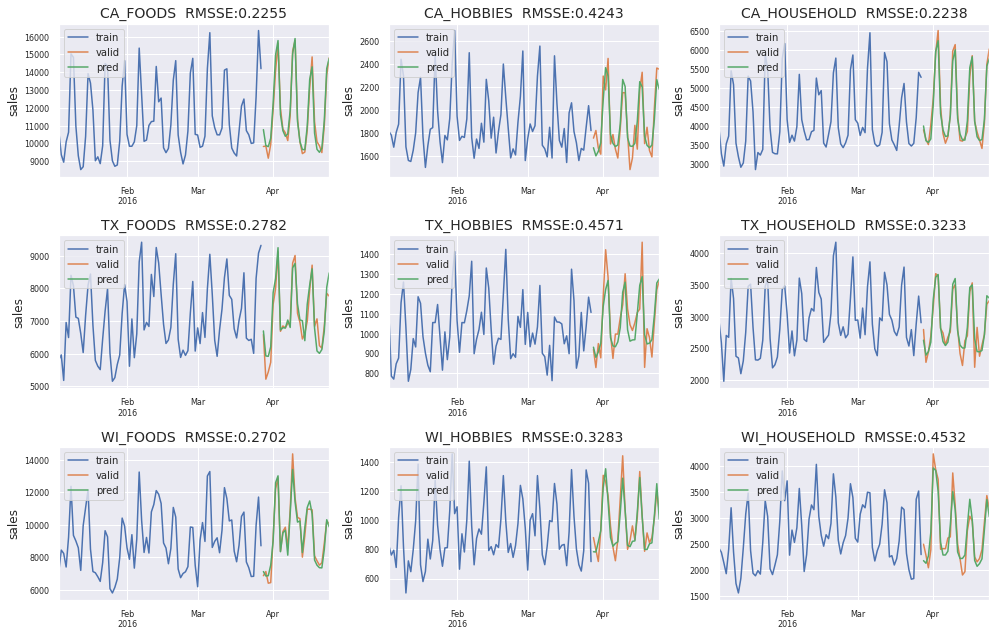

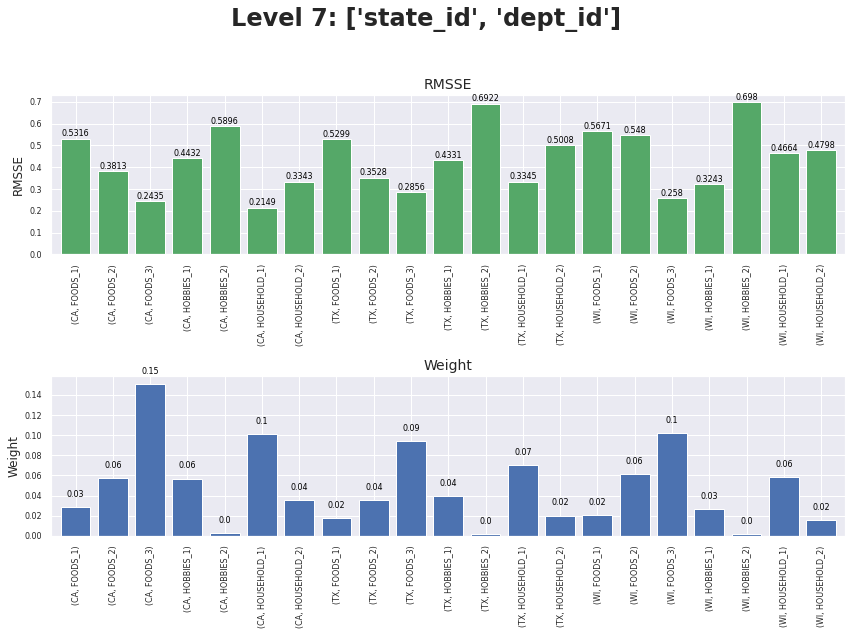

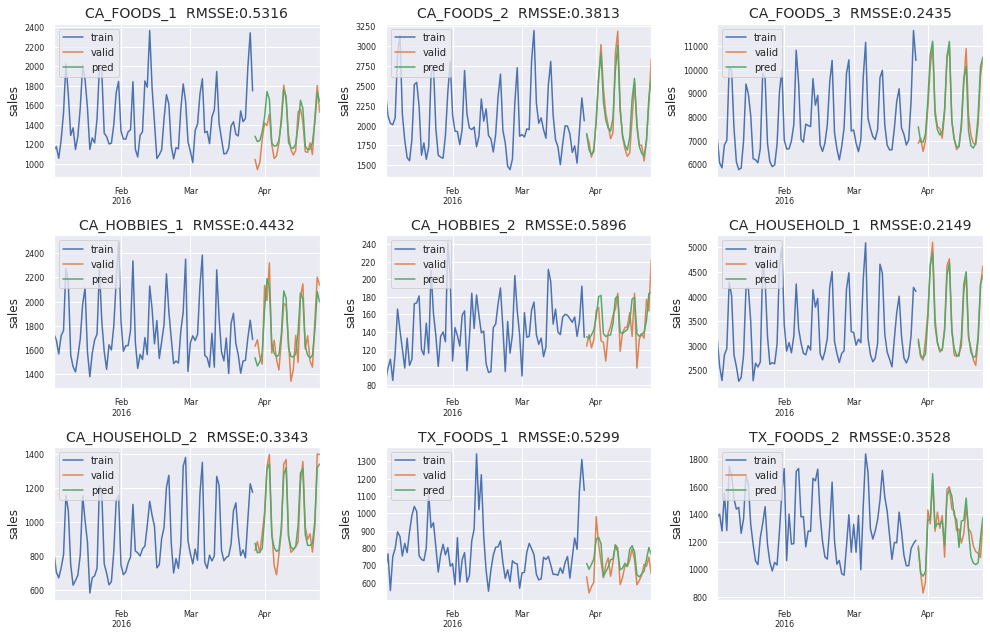

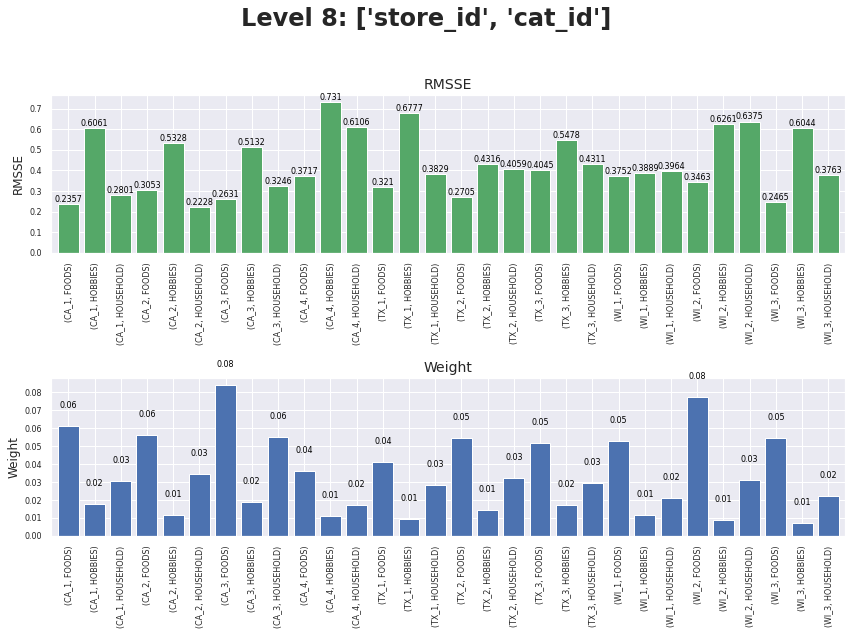

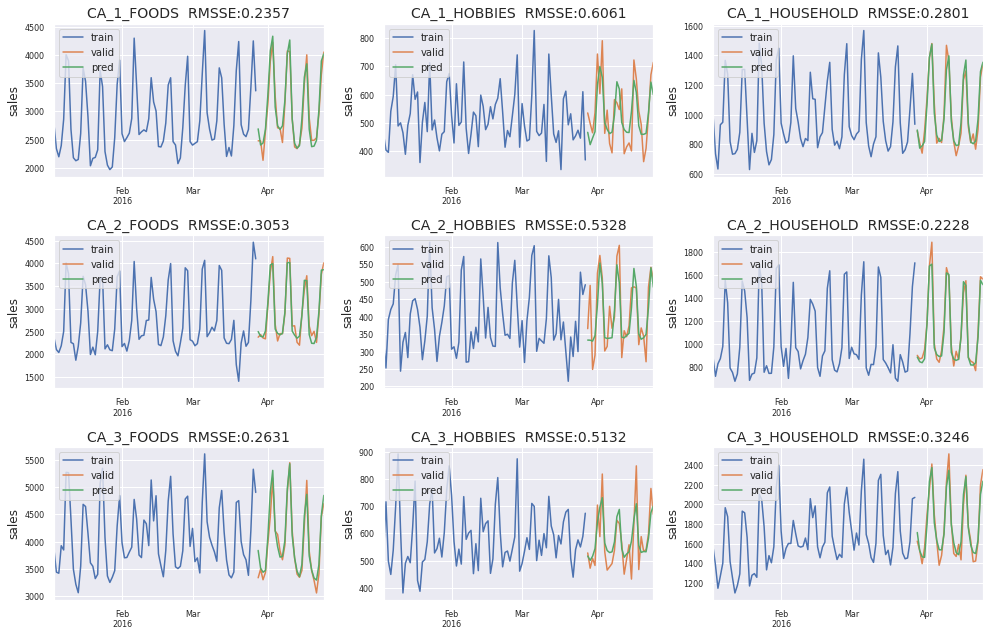

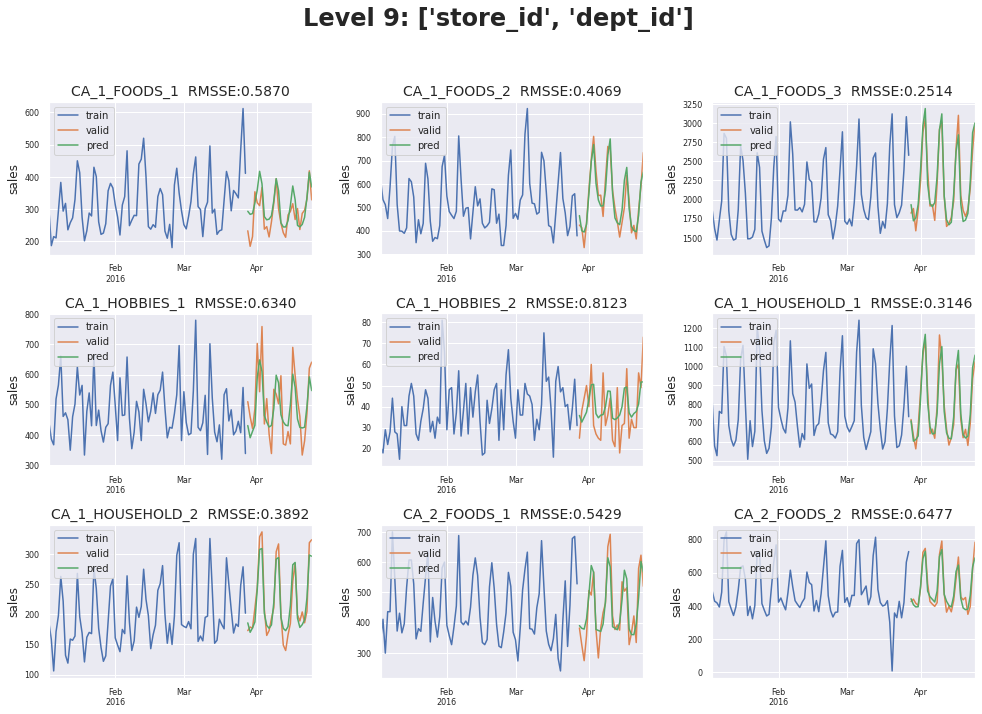

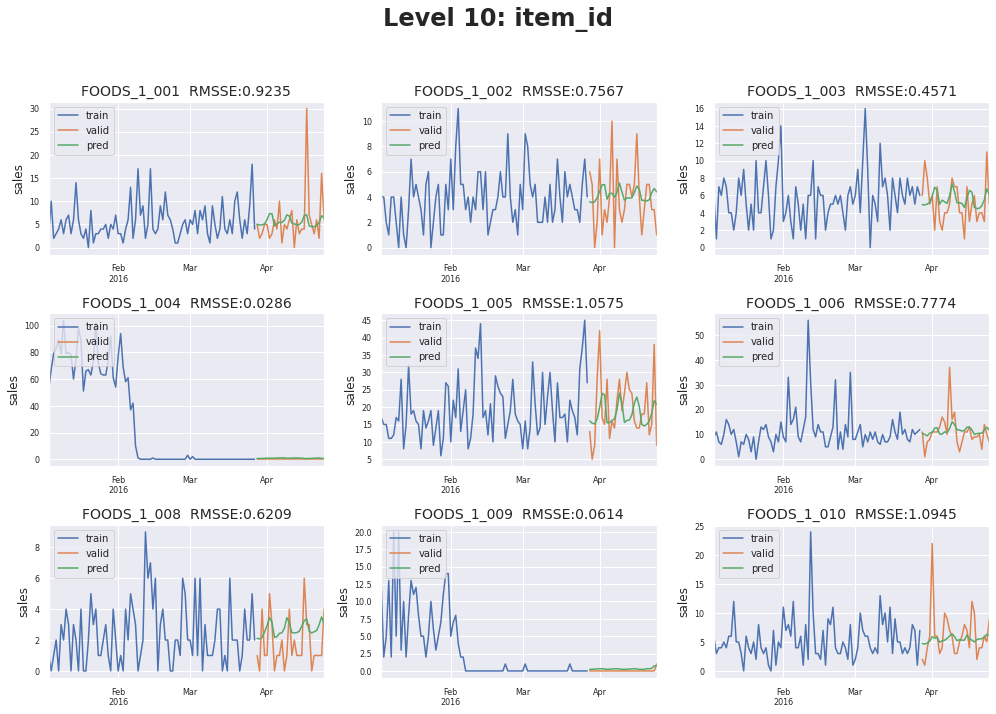

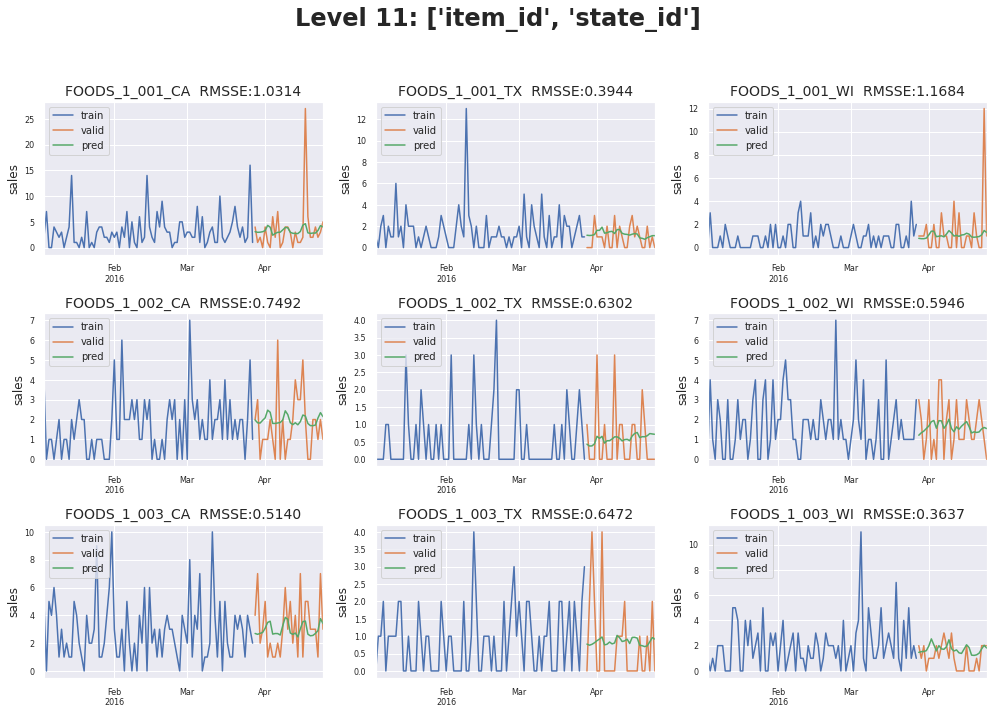

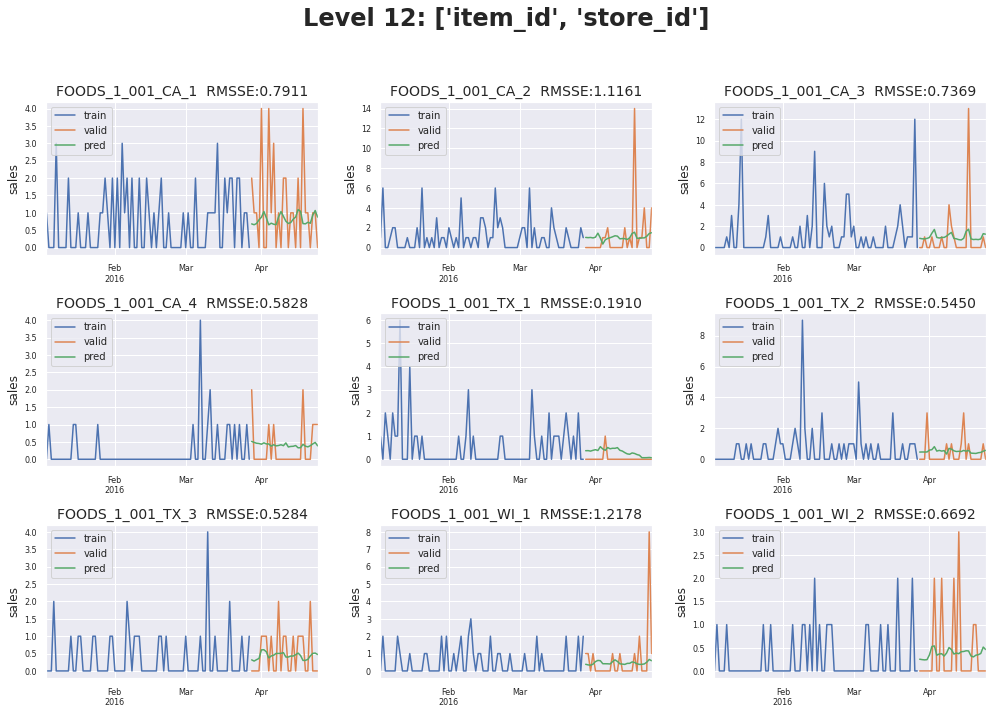

In [25]:
create_dashboard(evaluator)

#Predict

In [29]:
########################### Predict
#################################################################################

# Create Dummy DataFrame to store predictions
all_preds = pd.DataFrame()

# Join back the Test dataset with 
# a small part of the training data 
# to make recursive features
base_test = get_base_test()

# Timer to measure predictions time 
main_time = time.time()

# Loop over each prediction day
# As rolling lags are the most timeconsuming
# we will calculate it for whole day
for PREDICT_DAY in range(1,29):    
    print('Predict | Day:', PREDICT_DAY)
    start_time = time.time()

    # Make temporary grid to calculate rolling lags
    grid_df = base_test.copy()
    grid_df = pd.concat([grid_df, df_parallelize_run(make_lag_roll, ROLS_SPLIT)], axis=1)
        
    for store_id,cat_id in itertools.product(STORES_IDS, CATEGORIES_IDS):
        
        # Read all our models and make predictions
        # for each day/store pairs
        model_path = AUX_MODELS + 'lgb_model_'+store_id+"_"+cat_id+'_v'+str(VER)+'.bin' 
        if USE_AUX:
            model_path = AUX_MODELS + model_path
        
        estimator = pickle.load(open(model_path, 'rb'))
        
        day_mask = base_test['d']==(END_TRAIN+PREDICT_DAY)
        store_mask = (base_test['store_id']==store_id) & (base_test['cat_id']==cat_id) 
        
        mask = (day_mask)&(store_mask)
        base_test[TARGET][mask] = estimator.predict(grid_df[mask][MODEL_FEATURES])
    
    # Make good column naming and add 
    # to all_preds DataFrame
    temp_df = base_test[day_mask][['id',TARGET]]
    temp_df.columns = ['id','F'+str(PREDICT_DAY)]
    if 'id' in list(all_preds):
        all_preds = all_preds.merge(temp_df, on=['id'], how='left')
    else:
        all_preds = temp_df.copy()
        
    print('#'*10, ' %0.2f min round |' % ((time.time() - start_time) / 60),
                  ' %0.2f min total |' % ((time.time() - main_time) / 60),
                  ' %0.2f day sales |' % (temp_df['F'+str(PREDICT_DAY)].sum()))
    del temp_df
    
all_preds = all_preds.reset_index(drop=True)
all_preds

Predict | Day: 1
##########  2.24 min round |  2.24 min total |  37006.78 day sales |
Predict | Day: 2
##########  2.24 min round |  4.49 min total |  35252.76 day sales |
Predict | Day: 3
##########  2.23 min round |  6.72 min total |  34674.29 day sales |
Predict | Day: 4
##########  2.23 min round |  8.95 min total |  35203.55 day sales |
Predict | Day: 5
##########  2.23 min round |  11.19 min total |  41422.84 day sales |
Predict | Day: 6
##########  2.23 min round |  13.42 min total |  50214.40 day sales |
Predict | Day: 7
##########  2.22 min round |  15.65 min total |  53338.40 day sales |
Predict | Day: 8
##########  2.23 min round |  17.88 min total |  44088.50 day sales |
Predict | Day: 9
##########  2.23 min round |  20.11 min total |  44202.71 day sales |
Predict | Day: 10
##########  2.23 min round |  22.35 min total |  38763.98 day sales |
Predict | Day: 11
##########  2.23 min round |  24.57 min total |  40230.88 day sales |
Predict | Day: 12
##########  2.24 min round 

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0.769870,0.727184,0.729390,0.675529,0.828095,1.097213,1.138429,0.841683,0.789225,0.809139,0.774255,0.899149,1.039428,0.774084,0.796669,0.708916,0.687443,0.642488,0.702056,1.040769,0.985442,0.824318,0.720870,0.706686,0.707567,0.818112,1.011257,0.902597
1,HOBBIES_1_002_CA_1_validation,0.173752,0.176630,0.173267,0.202966,0.231959,0.255297,0.289840,0.226916,0.221011,0.193060,0.188280,0.205684,0.242587,0.227814,0.166082,0.158282,0.157424,0.164869,0.195859,0.240426,0.259382,0.169099,0.171690,0.191572,0.189952,0.221179,0.271688,0.285745
2,HOBBIES_1_003_CA_1_validation,0.426583,0.376567,0.412746,0.439822,0.572415,0.702399,0.675217,0.437735,0.438863,0.416221,0.454412,0.526489,0.712504,0.595710,0.464157,0.476899,0.467307,0.482610,0.537480,0.628580,0.633047,0.462443,0.437890,0.466922,0.436921,0.539126,0.696616,0.653354
3,HOBBIES_1_004_CA_1_validation,1.553241,1.320197,1.316906,1.692451,2.171744,3.200879,3.069184,1.618522,1.291402,1.237217,1.410938,1.604137,2.802294,2.409625,1.361091,1.294784,1.223313,1.388526,1.783291,2.433861,3.107306,1.528464,1.385482,1.293046,1.395476,1.910658,3.007576,3.471313
4,HOBBIES_1_005_CA_1_validation,0.803452,0.735651,0.824881,0.856461,1.064443,1.333422,1.563001,0.929291,0.911344,0.853290,0.881792,1.023582,1.487737,1.109962,0.927725,0.879914,0.909638,0.916468,1.038086,1.485633,1.542682,0.982462,0.908727,0.947046,0.927435,1.141139,1.567515,1.502663
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_validation,0.364217,0.334297,0.325014,0.320297,0.374409,0.428469,0.418996,0.552177,0.543749,0.434061,0.508118,0.519094,0.518289,0.670896,0.486176,0.431150,0.487530,0.444643,0.447883,0.568940,0.695650,0.495022,0.431525,0.425715,0.406405,0.422498,0.429460,0.509002
30486,FOODS_3_824_WI_3_validation,0.258013,0.247855,0.241309,0.227917,0.257464,0.262296,0.335739,0.308495,0.327373,0.265071,0.275236,0.276107,0.342815,0.374088,0.373541,0.297629,0.341267,0.337795,0.280033,0.432539,0.549058,0.361024,0.293935,0.253816,0.224522,0.222206,0.309097,0.303064
30487,FOODS_3_825_WI_3_validation,0.657818,0.524647,0.479728,0.523183,0.639492,0.764437,0.955092,1.158719,1.157958,0.881978,1.162260,1.279825,1.431057,1.469709,1.473277,1.001737,1.190645,1.253258,0.997960,1.493862,1.462326,1.130330,0.801666,0.696658,0.585213,0.661630,0.913565,0.813654
30488,FOODS_3_826_WI_3_validation,0.940746,0.940927,0.812313,0.851074,0.998226,1.270379,1.211210,1.304926,1.295068,0.850883,1.068060,1.116215,1.198615,1.208608,1.215355,0.943499,1.082416,1.144047,0.968075,1.398323,1.432131,0.959596,0.927724,0.882715,0.829418,1.053734,1.101683,1.208955


In [0]:
########################### Export
#################################################################################
# Reading competition sample submission and
# merging our predictions
# As we have predictions only for "_validation" data
# we need to do fillna() for "_evaluation" items
submission = pd.read_csv(ORIGINAL+'sample_submission.csv')[['id']]
submission = submission.merge(all_preds, on=['id'], how='left').fillna(0)
submission.to_csv(AUX_MODELS+'submission_cat_v'+str(VER)+'.csv', index=False)
submission.to_csv('submission_cat_v'+str(VER)+'.csv', index=False)



In [0]:
# Summary

# Of course here is no magic at all.
# No "Novel" features and no brilliant ideas.
# We just carefully joined all
# our previous fe work and created a model.

# Also!
# In my opinion this strategy is a "dead end".
# Overfits a lot LB and with 1 final submission 
# you have no option to risk.


# Improvement should come from:
# Loss function
# Data representation
# Stable CV
# Good features reduction strategy
# Predictions stabilization with NN
# Trend prediction
# Real zero sales detection/classification


# Good kernels references 
## (the order is random and the list is not complete):
# https://www.kaggle.com/ragnar123/simple-lgbm-groupkfold-cv
# https://www.kaggle.com/jpmiller/grouping-items-by-stockout-pattern
# https://www.kaggle.com/headsortails/back-to-predict-the-future-interactive-m5-eda
# https://www.kaggle.com/sibmike/m5-out-of-stock-feature
# https://www.kaggle.com/mayer79/m5-forecast-attack-of-the-data-table
# https://www.kaggle.com/yassinealouini/seq2seq
# https://www.kaggle.com/kailex/m5-forecaster-v2
# https://www.kaggle.com/aerdem4/m5-lofo-importance-on-gpu-via-rapids-xgboost


# Features were created in these kernels:
## 
# Mean encodings and PCA options
# https://www.kaggle.com/kyakovlev/m5-custom-features
##
# Lags and rolling lags
# https://www.kaggle.com/kyakovlev/m5-lags-features
##
# Base Grid and base features (calendar/price/etc)
# https://www.kaggle.com/kyakovlev/m5-simple-fe


# Personal request
# Please don't upvote any ensemble and copypaste kernels
## The worst case is ensemble without any analyse.
## The best choice - just ignore it.
## I would like to see more kernels with interesting and original approaches.
## Don't feed copypasters with upvotes.

## It doesn't mean that you should not fork and improve others kernels
## but I would like to see params and code tuning based on some CV and analyse
## and not only on LB probing.
## Small changes could be shared in comments and authors can improve their kernel.

## Feel free to criticize this kernel as my knowlege is very limited
## and I can be wrong in code and descriptions. 
## Thank you.

In [0]:
grid_df, features_columns = get_data_by_store("CA_1")

In [0]:
grid_df.columns

Index(['id', 'd', 'sales', 'item_id', 'dept_id', 'cat_id', 'release',
       'sell_price', 'price_max', 'price_min', 'price_std', 'price_mean',
       'price_norm', 'price_nunique', 'item_nunique', 'price_momentum',
       'price_momentum_m', 'price_momentum_y', 'event_name_1', 'event_type_1',
       'event_name_2', 'event_type_2', 'tm_d', 'tm_w', 'tm_m', 'tm_y', 'tm_wm',
       'tm_dw', 'tm_w_end', 'enc_cat_id_mean', 'enc_cat_id_std',
       'enc_dept_id_mean', 'enc_dept_id_std', 'enc_item_id_mean',
       'enc_item_id_std', 'sales_lag_28', 'sales_lag_29', 'sales_lag_30',
       'sales_lag_31', 'sales_lag_32', 'sales_lag_33', 'sales_lag_34',
       'sales_lag_35', 'sales_lag_36', 'sales_lag_37', 'sales_lag_38',
       'sales_lag_39', 'sales_lag_40', 'sales_lag_41', 'sales_lag_42',
       'rolling_mean_7', 'rolling_std_7', 'rolling_mean_14', 'rolling_std_14',
       'rolling_mean_30', 'rolling_std_30', 'rolling_mean_60',
       'rolling_std_60', 'rolling_mean_180', 'rolling_std_180',
 

In [0]:
features_columns

['item_id',
 'dept_id',
 'cat_id',
 'release',
 'sell_price',
 'price_max',
 'price_min',
 'price_std',
 'price_mean',
 'price_norm',
 'price_nunique',
 'item_nunique',
 'price_momentum',
 'price_momentum_m',
 'price_momentum_y',
 'event_name_1',
 'event_type_1',
 'event_name_2',
 'event_type_2',
 'tm_d',
 'tm_w',
 'tm_m',
 'tm_y',
 'tm_wm',
 'tm_dw',
 'tm_w_end',
 'enc_cat_id_mean',
 'enc_cat_id_std',
 'enc_dept_id_mean',
 'enc_dept_id_std',
 'enc_item_id_mean',
 'enc_item_id_std',
 'sales_lag_28',
 'sales_lag_29',
 'sales_lag_30',
 'sales_lag_31',
 'sales_lag_32',
 'sales_lag_33',
 'sales_lag_34',
 'sales_lag_35',
 'sales_lag_36',
 'sales_lag_37',
 'sales_lag_38',
 'sales_lag_39',
 'sales_lag_40',
 'sales_lag_41',
 'sales_lag_42',
 'rolling_mean_7',
 'rolling_std_7',
 'rolling_mean_14',
 'rolling_std_14',
 'rolling_mean_30',
 'rolling_std_30',
 'rolling_mean_60',
 'rolling_std_60',
 'rolling_mean_180',
 'rolling_std_180',
 'rolling_mean_tmp_1_7',
 'rolling_mean_tmp_1_14',
 'rolling_m

In [0]:
imp=pd.DataFrame({'feature': features_columns,

 'importance':estimator.feature_importance()}).sort_values('importance',

 ascending=False)
imp.to_csv(AUX_MODELS+'importance_v'+str(VER)+'.csv', index=False)

In [0]:
grid_df.last_sale

AttributeError: ignored